# Null Model Training

This notebook trains ML models on null networks (degree-preserving permutations) to create degree-aware null models.

## Purpose

Train models that predict edge probabilities based **only** on degree structure (no biological signal):
- **Training data**: Permutations 1-20 (null networks)
- **Validation data**: Permutations 21-30 (held-out nulls)
- **Test data**: Hetionet (perm 0) vs validation nulls

## Key Features

- **No data leakage**: Hetionet never seen during training
- **Two models**: Polynomial Logistic Regression (fast) + Random Forest (accurate)
- **Error analysis**: Performance stratified by degree bins
- **All 24 edge types**: Complete null model library

## Workflow

1. Load null edge frequencies (perms 1-20)
2. Train Polynomial LogReg and Random Forest
3. Validate on held-out nulls (perms 21-30)
4. Error analysis by degree
5. Save models and validation results

In [1]:
# Papermill parameters
training_perm_range = (1, 21)  # Permutations 1-20 for training
validation_perm_range = (21, 31)  # Permutations 21-30 for validation
edge_types_to_process = None  # None = all 24 edge types

In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr
import joblib
import warnings
warnings.filterwarnings('ignore')

# Setup paths
repo_dir = Path.cwd()
data_dir = repo_dir / 'data'
results_dir = repo_dir / 'results' / 'null_models'
results_dir.mkdir(parents=True, exist_ok=True)

print(f"Repository directory: {repo_dir}")
print(f"Data directory: {data_dir}")
print(f"Results will be saved to: {results_dir}")

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

Repository directory: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability
Data directory: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/data
Results will be saved to: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/null_models


## 1. Define Edge Types and Helper Functions

In [3]:
# All 24 edge types
ALL_EDGE_TYPES = [
    "AdG", "AeG", "AuG", "CbG", "CcSE", "CdG", "CpD", "CrC", "CtD", "CuG",
    "DaG", "DdG", "DlA", "DpS", "DrD", "DuG", "GcG", "GiG", "GpBP", "GpCC",
    "GpMF", "GpPW", "Gr>G", "PCiC"
]

# Use provided edge_types or default to all
if edge_types_to_process is None:
    edge_types_to_process = ALL_EDGE_TYPES

print(f"Processing {len(edge_types_to_process)} edge types")
print(f"Training permutations: {training_perm_range[0]}-{training_perm_range[1]-1}")
print(f"Validation permutations: {validation_perm_range[0]}-{validation_perm_range[1]-1}")

Processing 24 edge types
Training permutations: 1-20
Validation permutations: 21-30


In [4]:
def load_null_edge_frequencies(edge_type, perm_ids, negative_sample_ratio=0.1):
    """
    Load and aggregate edge frequencies from null permutations.
    
    Parameters:
    -----------
    edge_type : str
        Edge type (e.g., 'CbG')
    perm_ids : list or range
        Permutation IDs to load
    negative_sample_ratio : float
        Ratio of negative samples to positive samples
        
    Returns:
    --------
    pd.DataFrame with columns: source_degree, target_degree, edge_probability
    """
    all_pairs = []
    
    for perm_id in perm_ids:
        edge_file = data_dir / 'permutations' / f'{perm_id:03d}.hetmat' / 'edges' / f'{edge_type}.sparse.npz'
        
        if not edge_file.exists():
            print(f"  Warning: File not found: {edge_file}")
            continue
        
        # Load edge matrix
        matrix = sp.load_npz(str(edge_file))
        source_degrees = np.array(matrix.sum(axis=1)).flatten()
        target_degrees = np.array(matrix.sum(axis=0)).flatten()
        
        # Positive examples (edges)
        for i, j in zip(*matrix.nonzero()):
            all_pairs.append({
                'source_degree': int(source_degrees[i]),
                'target_degree': int(target_degrees[j]),
                'edge_exists': 1
            })
        
        # Negative examples (sample non-edges)
        n_nodes_source, n_nodes_target = matrix.shape
        n_negatives = int(matrix.nnz * negative_sample_ratio)
        
        sampled = 0
        attempts = 0
        max_attempts = n_negatives * 10
        
        while sampled < n_negatives and attempts < max_attempts:
            i = np.random.randint(0, n_nodes_source)
            j = np.random.randint(0, n_nodes_target)
            
            if matrix[i, j] == 0 and source_degrees[i] > 0 and target_degrees[j] > 0:
                all_pairs.append({
                    'source_degree': int(source_degrees[i]),
                    'target_degree': int(target_degrees[j]),
                    'edge_exists': 0
                })
                sampled += 1
            attempts += 1
    
    # Convert to DataFrame and aggregate
    df = pd.DataFrame(all_pairs)
    
    if len(df) == 0:
        return pd.DataFrame(columns=['source_degree', 'target_degree', 'edge_probability'])
    
    # Aggregate by degree pair
    null_freq = df.groupby(['source_degree', 'target_degree']).agg({
        'edge_exists': ['sum', 'count', 'mean']
    }).reset_index()
    
    null_freq.columns = ['source_degree', 'target_degree', 'edge_count', 'total_count', 'edge_probability']
    
    return null_freq

In [5]:
def analyze_errors_by_degree(predictions, actuals, source_degrees, target_degrees):
    """
    Analyze prediction errors stratified by degree bins.
    """
    # Define degree bins
    degree_bins = [0, 1, 2, 5, 10, 20, 50, 100, 500, np.inf]
    degree_labels = ['0', '1', '2-4', '5-9', '10-19', '20-49', '50-99', '100-499', '500+']
    
    results = []
    
    # Bin degrees
    source_bins = pd.cut(source_degrees, bins=degree_bins, labels=degree_labels)
    target_bins = pd.cut(target_degrees, bins=degree_bins, labels=degree_labels)
    
    # Error metrics by source degree
    for bin_label in degree_labels:
        mask = source_bins == bin_label
        if mask.sum() >= 10:
            results.append({
                'stratification': 'source_degree',
                'bin': bin_label,
                'n_samples': int(mask.sum()),
                'mean_prediction': float(predictions[mask].mean()),
                'mean_actual': float(actuals[mask].mean()),
                'mae': float(np.abs(predictions[mask] - actuals[mask]).mean()),
                'rmse': float(np.sqrt(((predictions[mask] - actuals[mask])**2).mean())),
                'correlation': float(np.corrcoef(predictions[mask], actuals[mask])[0,1]) if mask.sum() > 1 else np.nan,
                'mean_degree': float(source_degrees[mask].mean())
            })
    
    # Error metrics by target degree
    for bin_label in degree_labels:
        mask = target_bins == bin_label
        if mask.sum() >= 10:
            results.append({
                'stratification': 'target_degree',
                'bin': bin_label,
                'n_samples': int(mask.sum()),
                'mean_prediction': float(predictions[mask].mean()),
                'mean_actual': float(actuals[mask].mean()),
                'mae': float(np.abs(predictions[mask] - actuals[mask]).mean()),
                'rmse': float(np.sqrt(((predictions[mask] - actuals[mask])**2).mean())),
                'correlation': float(np.corrcoef(predictions[mask], actuals[mask])[0,1]) if mask.sum() > 1 else np.nan,
                'mean_degree': float(target_degrees[mask].mean())
            })
    
    # Error metrics by degree product
    degree_products = source_degrees * target_degrees
    product_bins = pd.cut(degree_products, 
                          bins=[0, 1, 10, 100, 1000, 10000, 100000, np.inf],
                          labels=['0-1', '2-10', '11-100', '101-1K', '1K-10K', '10K-100K', '100K+'])
    
    for bin_label in product_bins.unique():
        if pd.notna(bin_label):
            mask = product_bins == bin_label
            if mask.sum() >= 10:
                results.append({
                    'stratification': 'degree_product',
                    'bin': str(bin_label),
                    'n_samples': int(mask.sum()),
                    'mean_prediction': float(predictions[mask].mean()),
                    'mean_actual': float(actuals[mask].mean()),
                    'mae': float(np.abs(predictions[mask] - actuals[mask]).mean()),
                    'rmse': float(np.sqrt(((predictions[mask] - actuals[mask])**2).mean())),
                    'correlation': float(np.corrcoef(predictions[mask], actuals[mask])[0,1]) if mask.sum() > 1 else np.nan,
                    'mean_product': float(degree_products[mask].mean())
                })
    
    return pd.DataFrame(results)

## 2. Train Null Models for All Edge Types

In [6]:
training_results = []

for edge_type in edge_types_to_process:
    print(f"\n{'='*70}")
    print(f"Training null models for {edge_type}")
    print(f"{'='*70}")
    
    # Load training data (perms 1-20)
    print(f"Loading training data from permutations {training_perm_range[0]}-{training_perm_range[1]-1}...")
    train_freq = load_null_edge_frequencies(
        edge_type, 
        range(training_perm_range[0], training_perm_range[1])
    )
    
    if len(train_freq) == 0:
        print(f"  ⚠ No training data found for {edge_type}, skipping...")
        continue
    
    print(f"  Training samples: {len(train_freq):,}")
    print(f"  Source degree range: {train_freq['source_degree'].min()}-{train_freq['source_degree'].max()}")
    print(f"  Target degree range: {train_freq['target_degree'].min()}-{train_freq['target_degree'].max()}")
    print(f"  Mean edge probability: {train_freq['edge_probability'].mean():.4f}")
    
    # Prepare features and targets
    X_train = train_freq[['source_degree', 'target_degree']].values
    y_train = train_freq['edge_probability'].values
    
    # Train Polynomial Logistic Regression
    print(f"\nTraining Polynomial Logistic Regression...")
    poly_features = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train)
    
    poly_model = Ridge(alpha=1.0, random_state=42)
    poly_model.fit(X_train_poly, y_train)
    
    # Train Random Forest
    print(f"Training Random Forest...")
    rf_model = RandomForestRegressor(
        n_estimators=100, 
        max_depth=10, 
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    
    # Save models
    poly_model_file = results_dir / f'{edge_type}_poly_null.pkl'
    poly_features_file = results_dir / f'{edge_type}_poly_features.pkl'
    rf_model_file = results_dir / f'{edge_type}_rf_null.pkl'
    
    joblib.dump(poly_model, poly_model_file)
    joblib.dump(poly_features, poly_features_file)
    joblib.dump(rf_model, rf_model_file)
    
    print(f"  ✓ Saved models:")
    print(f"    - {poly_model_file.name}")
    print(f"    - {poly_features_file.name}")
    print(f"    - {rf_model_file.name}")
    
    training_results.append({
        'edge_type': edge_type,
        'n_training_samples': len(train_freq),
        'mean_edge_prob': train_freq['edge_probability'].mean(),
        'poly_model_file': str(poly_model_file),
        'rf_model_file': str(rf_model_file)
    })

training_df = pd.DataFrame(training_results)
print(f"\n{'='*70}")
print(f"TRAINING COMPLETE")
print(f"{'='*70}")
print(f"Successfully trained models for {len(training_df)} edge types")
print(f"Total model files: {len(training_df) * 3}")


Training null models for AdG
Loading training data from permutations 1-20...


  Training samples: 1,116
  Source degree range: 1149-6182
  Target degree range: 1-31
  Mean edge probability: 0.9524

Training Polynomial Logistic Regression...


Training Random Forest...


  ✓ Saved models:
    - AdG_poly_null.pkl
    - AdG_poly_features.pkl
    - AdG_rf_null.pkl

Training null models for AeG
Loading training data from permutations 1-20...


  Training samples: 13,237
  Source degree range: 1-15036
  Target degree range: 1-98
  Mean edge probability: 0.6190

Training Polynomial Logistic Regression...
Training Random Forest...


  ✓ Saved models:
    - AeG_poly_null.pkl
    - AeG_poly_features.pkl
    - AeG_rf_null.pkl

Training null models for AuG
Loading training data from permutations 1-20...


  Training samples: 864
  Source degree range: 1037-5092
  Target degree range: 1-24
  Mean edge probability: 0.9476

Training Polynomial Logistic Regression...
Training Random Forest...
  ✓ Saved models:
    - AuG_poly_null.pkl
    - AuG_poly_features.pkl
    - AuG_rf_null.pkl

Training null models for CbG
Loading training data from permutations 1-20...


  Training samples: 4,093
  Source degree range: 1-132
  Target degree range: 1-516
  Mean edge probability: 0.9830

Training Polynomial Logistic Regression...
Training Random Forest...
  ✓ Saved models:
    - CbG_poly_null.pkl
    - CbG_poly_features.pkl
    - CbG_rf_null.pkl

Training null models for CcSE
Loading training data from permutations 1-20...


  Training samples: 102,390
  Source degree range: 1-839
  Target degree range: 1-932
  Mean edge probability: 0.9459

Training Polynomial Logistic Regression...
Training Random Forest...


  ✓ Saved models:
    - CcSE_poly_null.pkl
    - CcSE_poly_features.pkl
    - CcSE_rf_null.pkl

Training null models for CdG
Loading training data from permutations 1-20...


  Training samples: 7,198
  Source degree range: 1-250
  Target degree range: 1-164
  Mean edge probability: 0.9690

Training Polynomial Logistic Regression...
Training Random Forest...


  ✓ Saved models:
    - CdG_poly_null.pkl
    - CdG_poly_features.pkl
    - CdG_rf_null.pkl

Training null models for CpD
Loading training data from permutations 1-20...


  Training samples: 159
  Source degree range: 1-9
  Target degree range: 1-30
  Mean edge probability: 0.9662

Training Polynomial Logistic Regression...
Training Random Forest...
  ✓ Saved models:
    - CpD_poly_null.pkl
    - CpD_poly_features.pkl
    - CpD_rf_null.pkl

Training null models for CrC
Loading training data from permutations 1-20...


  Training samples: 2,295
  Source degree range: 1-58
  Target degree range: 1-58
  Mean edge probability: 0.9424

Training Polynomial Logistic Regression...
Training Random Forest...
  ✓ Saved models:
    - CrC_poly_null.pkl
    - CrC_poly_features.pkl
    - CrC_rf_null.pkl

Training null models for CtD
Loading training data from permutations 1-20...


  Training samples: 408
  Source degree range: 1-19
  Target degree range: 1-68
  Mean edge probability: 0.9540

Training Polynomial Logistic Regression...
Training Random Forest...
  ✓ Saved models:
    - CtD_poly_null.pkl
    - CtD_poly_features.pkl
    - CtD_rf_null.pkl

Training null models for CuG
Loading training data from permutations 1-20...


  Training samples: 6,028
  Source degree range: 1-250
  Target degree range: 1-119
  Mean edge probability: 0.9716

Training Polynomial Logistic Regression...
Training Random Forest...


  ✓ Saved models:
    - CuG_poly_null.pkl
    - CuG_poly_features.pkl
    - CuG_rf_null.pkl

Training null models for DaG
Loading training data from permutations 1-20...


  Training samples: 3,268
  Source degree range: 1-550
  Target degree range: 1-47
  Mean edge probability: 0.9448

Training Polynomial Logistic Regression...
Training Random Forest...


  ✓ Saved models:
    - DaG_poly_null.pkl
    - DaG_poly_features.pkl
    - DaG_rf_null.pkl

Training null models for DdG
Loading training data from permutations 1-20...


  Training samples: 98
  Source degree range: 1-250
  Target degree range: 1-6
  Mean edge probability: 0.7715

Training Polynomial Logistic Regression...
Training Random Forest...
  ✓ Saved models:
    - DdG_poly_null.pkl
    - DdG_poly_features.pkl
    - DdG_rf_null.pkl

Training null models for DlA
Loading training data from permutations 1-20...


  Training samples: 1,349
  Source degree range: 4-128
  Target degree range: 1-36
  Mean edge probability: 0.8896

Training Polynomial Logistic Regression...
Training Random Forest...
  ✓ Saved models:
    - DlA_poly_null.pkl
    - DlA_poly_features.pkl
    - DlA_rf_null.pkl

Training null models for DpS
Loading training data from permutations 1-20...


  Training samples: 1,819
  Source degree range: 1-116
  Target degree range: 1-49
  Mean edge probability: 0.9071

Training Polynomial Logistic Regression...
Training Random Forest...
  ✓ Saved models:
    - DpS_poly_null.pkl
    - DpS_poly_features.pkl
    - DpS_rf_null.pkl

Training null models for DrD
Loading training data from permutations 1-20...


  Training samples: 620
  Source degree range: 1-33
  Target degree range: 1-33
  Mean edge probability: 0.8961

Training Polynomial Logistic Regression...
Training Random Forest...
  ✓ Saved models:
    - DrD_poly_null.pkl
    - DrD_poly_features.pkl
    - DrD_rf_null.pkl

Training null models for DuG
Loading training data from permutations 1-20...


  Training samples: 126
  Source degree range: 1-250
  Target degree range: 1-9
  Mean edge probability: 0.7707

Training Polynomial Logistic Regression...
Training Random Forest...
  ✓ Saved models:
    - DuG_poly_null.pkl
    - DuG_poly_features.pkl
    - DuG_rf_null.pkl

Training null models for GcG
Loading training data from permutations 1-20...


  Training samples: 37,865
  Source degree range: 1-454
  Target degree range: 1-454
  Mean edge probability: 0.9932

Training Polynomial Logistic Regression...
Training Random Forest...


  ✓ Saved models:
    - GcG_poly_null.pkl
    - GcG_poly_features.pkl
    - GcG_rf_null.pkl

Training null models for GiG
Loading training data from permutations 1-20...


  Training samples: 90,354
  Source degree range: 1-8611
  Target degree range: 1-8611
  Mean edge probability: 0.9882

Training Polynomial Logistic Regression...
Training Random Forest...


  ✓ Saved models:
    - GiG_poly_null.pkl
    - GiG_poly_features.pkl
    - GiG_rf_null.pkl

Training null models for GpBP
Loading training data from permutations 1-20...


  Training samples: 217,405
  Source degree range: 1-799
  Target degree range: 2-999
  Mean edge probability: 0.9810

Training Polynomial Logistic Regression...
Training Random Forest...


  ✓ Saved models:
    - GpBP_poly_null.pkl
    - GpBP_poly_features.pkl
    - GpBP_rf_null.pkl

Training null models for GpCC
Loading training data from permutations 1-20...


  Training samples: 13,309
  Source degree range: 1-66
  Target degree range: 2-1000
  Mean edge probability: 0.9622

Training Polynomial Logistic Regression...
Training Random Forest...


  ✓ Saved models:
    - GpCC_poly_null.pkl
    - GpCC_poly_features.pkl
    - GpCC_rf_null.pkl

Training null models for GpMF
Loading training data from permutations 1-20...


  Training samples: 12,606
  Source degree range: 1-55
  Target degree range: 2-955
  Mean edge probability: 0.9700

Training Polynomial Logistic Regression...
Training Random Forest...


  ✓ Saved models:
    - GpMF_poly_null.pkl
    - GpMF_poly_features.pkl
    - GpMF_rf_null.pkl

Training null models for GpPW
Loading training data from permutations 1-20...


  Training samples: 24,945
  Source degree range: 1-231
  Target degree range: 2-1956
  Mean edge probability: 0.9714

Training Polynomial Logistic Regression...
Training Random Forest...


  ✓ Saved models:
    - GpPW_poly_null.pkl
    - GpPW_poly_features.pkl
    - GpPW_rf_null.pkl

Training null models for Gr>G
Loading training data from permutations 1-20...


  Training samples: 102,554
  Source degree range: 1-383
  Target degree range: 1-1710
  Mean edge probability: 0.9684

Training Polynomial Logistic Regression...
Training Random Forest...


  ✓ Saved models:
    - Gr>G_poly_null.pkl
    - Gr>G_poly_features.pkl
    - Gr>G_rf_null.pkl

Training null models for PCiC
Loading training data from permutations 1-20...


  Training samples: 188
  Source degree range: 1-22
  Target degree range: 1-13
  Mean edge probability: 0.9808

Training Polynomial Logistic Regression...
Training Random Forest...
  ✓ Saved models:
    - PCiC_poly_null.pkl
    - PCiC_poly_features.pkl
    - PCiC_rf_null.pkl

TRAINING COMPLETE
Successfully trained models for 24 edge types
Total model files: 72


## 3. Validate on Held-Out Nulls

In [7]:
validation_results = []

for edge_type in edge_types_to_process:
    print(f"\nValidating {edge_type}...")
    
    # Check if models exist
    poly_model_file = results_dir / f'{edge_type}_poly_null.pkl'
    poly_features_file = results_dir / f'{edge_type}_poly_features.pkl'
    rf_model_file = results_dir / f'{edge_type}_rf_null.pkl'
    
    if not all([poly_model_file.exists(), rf_model_file.exists()]):
        print(f"  ⚠ Models not found, skipping...")
        continue
    
    # Load validation data (perms 21-30)
    val_freq = load_null_edge_frequencies(
        edge_type,
        range(validation_perm_range[0], validation_perm_range[1])
    )
    
    if len(val_freq) == 0:
        print(f"  ⚠ No validation data found, skipping...")
        continue
    
    X_val = val_freq[['source_degree', 'target_degree']].values
    y_val = val_freq['edge_probability'].values
    
    # Load models
    poly_model = joblib.load(poly_model_file)
    poly_features = joblib.load(poly_features_file)
    rf_model = joblib.load(rf_model_file)
    
    # Predict with Polynomial LogReg
    X_val_poly = poly_features.transform(X_val)
    y_pred_poly = poly_model.predict(X_val_poly)
    y_pred_poly = np.clip(y_pred_poly, 0, 1)  # Ensure valid probabilities
    
    # Predict with Random Forest
    y_pred_rf = rf_model.predict(X_val)
    y_pred_rf = np.clip(y_pred_rf, 0, 1)
    
    # Evaluate Polynomial LogReg
    corr_poly, _ = pearsonr(y_val, y_pred_poly)
    mae_poly = np.abs(y_val - y_pred_poly).mean()
    rmse_poly = np.sqrt(((y_val - y_pred_poly)**2).mean())
    
    # Evaluate Random Forest
    corr_rf, _ = pearsonr(y_val, y_pred_rf)
    mae_rf = np.abs(y_val - y_pred_rf).mean()
    rmse_rf = np.sqrt(((y_val - y_pred_rf)**2).mean())
    
    print(f"  Validation samples: {len(val_freq):,}")
    print(f"  Polynomial LogReg: r={corr_poly:.4f}, MAE={mae_poly:.4f}, RMSE={rmse_poly:.4f}")
    print(f"  Random Forest:     r={corr_rf:.4f}, MAE={mae_rf:.4f}, RMSE={rmse_rf:.4f}")
    
    # Error analysis by degree (using RF predictions)
    error_df = analyze_errors_by_degree(y_pred_rf, y_val, X_val[:, 0], X_val[:, 1])
    error_df['edge_type'] = edge_type
    
    # Save error analysis
    error_file = results_dir / f'{edge_type}_error_analysis.csv'
    error_df.to_csv(error_file, index=False)
    
    validation_results.append({
        'edge_type': edge_type,
        'n_validation_samples': len(val_freq),
        'poly_correlation': corr_poly,
        'poly_mae': mae_poly,
        'poly_rmse': rmse_poly,
        'rf_correlation': corr_rf,
        'rf_mae': mae_rf,
        'rf_rmse': rmse_rf
    })

validation_df = pd.DataFrame(validation_results)

print(f"\n{'='*70}")
print(f"VALIDATION COMPLETE")
print(f"{'='*70}")
print(f"\nValidation Summary:")
print(f"  Mean Poly correlation: {validation_df['poly_correlation'].mean():.4f}")
print(f"  Mean RF correlation:   {validation_df['rf_correlation'].mean():.4f}")
print(f"  Mean Poly RMSE:        {validation_df['poly_rmse'].mean():.4f}")
print(f"  Mean RF RMSE:          {validation_df['rf_rmse'].mean():.4f}")


Validating AdG...


  Validation samples: 1,116
  Polynomial LogReg: r=0.8936, MAE=0.0224, RMSE=0.0379
  Random Forest:     r=0.9945, MAE=0.0054, RMSE=0.0088

Validating AeG...


  Validation samples: 13,186
  Polynomial LogReg: r=0.9031, MAE=0.1177, RMSE=0.1756
  Random Forest:     r=0.9840, MAE=0.0302, RMSE=0.0720

Validating AuG...


  Validation samples: 864
  Polynomial LogReg: r=0.9027, MAE=0.0224, RMSE=0.0334
  Random Forest:     r=0.9886, MAE=0.0070, RMSE=0.0117

Validating CbG...


  Validation samples: 4,064
  Polynomial LogReg: r=0.4791, MAE=0.0224, RMSE=0.0481
  Random Forest:     r=0.8773, MAE=0.0113, RMSE=0.0260

Validating CcSE...


  Validation samples: 100,788
  Polynomial LogReg: r=0.5732, MAE=0.0654, RMSE=0.1276
  Random Forest:     r=0.8157, MAE=0.0362, RMSE=0.0892

Validating CdG...


  Validation samples: 7,134
  Polynomial LogReg: r=0.5905, MAE=0.0363, RMSE=0.0737
  Random Forest:     r=0.8836, MAE=0.0186, RMSE=0.0423

Validating CpD...


  Validation samples: 158
  Polynomial LogReg: r=0.5299, MAE=0.0306, RMSE=0.0661
  Random Forest:     r=0.4911, MAE=0.0289, RMSE=0.0706

Validating CrC...


  Validation samples: 2,294
  Polynomial LogReg: r=0.8024, MAE=0.0377, RMSE=0.0638
  Random Forest:     r=0.9487, MAE=0.0213, RMSE=0.0334

Validating CtD...


  Validation samples: 400
  Polynomial LogReg: r=0.5297, MAE=0.0449, RMSE=0.0867
  Random Forest:     r=0.6124, MAE=0.0342, RMSE=0.0830

Validating CuG...


  Validation samples: 5,944
  Polynomial LogReg: r=0.5943, MAE=0.0330, RMSE=0.0677
  Random Forest:     r=0.8659, MAE=0.0181, RMSE=0.0417

Validating DaG...


  Validation samples: 3,178
  Polynomial LogReg: r=0.5937, MAE=0.0575, RMSE=0.1173
  Random Forest:     r=0.7845, MAE=0.0331, RMSE=0.0901

Validating DdG...


  Validation samples: 99
  Polynomial LogReg: r=0.8153, MAE=0.1213, RMSE=0.1694
  Random Forest:     r=0.9067, MAE=0.0718, RMSE=0.1221

Validating DlA...


  Validation samples: 1,343
  Polynomial LogReg: r=0.7156, MAE=0.0683, RMSE=0.1185
  Random Forest:     r=0.7478, MAE=0.0607, RMSE=0.1128

Validating DpS...


  Validation samples: 1,799
  Polynomial LogReg: r=0.7192, MAE=0.0662, RMSE=0.1140
  Random Forest:     r=0.7813, MAE=0.0518, RMSE=0.1032

Validating DrD...


  Validation samples: 620
  Polynomial LogReg: r=0.7911, MAE=0.0620, RMSE=0.1035
  Random Forest:     r=0.8266, MAE=0.0558, RMSE=0.0954

Validating DuG...


  Validation samples: 124
  Polynomial LogReg: r=0.8179, MAE=0.1179, RMSE=0.1735
  Random Forest:     r=0.8542, MAE=0.0760, RMSE=0.1547

Validating GcG...


  Validation samples: 37,293
  Polynomial LogReg: r=0.4120, MAE=0.0099, RMSE=0.0295
  Random Forest:     r=0.9047, MAE=0.0042, RMSE=0.0137

Validating GiG...


  Validation samples: 89,438
  Polynomial LogReg: r=0.3076, MAE=0.0187, RMSE=0.0511
  Random Forest:     r=0.9405, MAE=0.0060, RMSE=0.0180

Validating GpBP...


  Validation samples: 215,393
  Polynomial LogReg: r=0.5396, MAE=0.0232, RMSE=0.0563
  Random Forest:     r=0.9191, MAE=0.0106, RMSE=0.0261

Validating GpCC...


  Validation samples: 13,078
  Polynomial LogReg: r=0.6136, MAE=0.0383, RMSE=0.0763
  Random Forest:     r=0.8869, MAE=0.0186, RMSE=0.0443

Validating GpMF...


  Validation samples: 12,394
  Polynomial LogReg: r=0.6168, MAE=0.0297, RMSE=0.0616
  Random Forest:     r=0.9143, MAE=0.0133, RMSE=0.0314

Validating GpPW...


  Validation samples: 24,748
  Polynomial LogReg: r=0.5180, MAE=0.0328, RMSE=0.0701
  Random Forest:     r=0.8953, MAE=0.0153, RMSE=0.0362

Validating Gr>G...


  Validation samples: 102,214
  Polynomial LogReg: r=0.5424, MAE=0.0375, RMSE=0.0813
  Random Forest:     r=0.8822, MAE=0.0195, RMSE=0.0452

Validating PCiC...


  Validation samples: 184
  Polynomial LogReg: r=0.6898, MAE=0.0163, RMSE=0.0313
  Random Forest:     r=0.7633, MAE=0.0135, RMSE=0.0278

VALIDATION COMPLETE

Validation Summary:
  Mean Poly correlation: 0.6455
  Mean RF correlation:   0.8529
  Mean Poly RMSE:        0.0848
  Mean RF RMSE:          0.0583


## 4. Save Validation Results

In [8]:
# Save validation results
validation_file = results_dir / 'validation_results.csv'
validation_df.to_csv(validation_file, index=False)
print(f"Saved validation results to: {validation_file}")

# Save training summary
training_file = results_dir / 'training_summary.csv'
training_df.to_csv(training_file, index=False)
print(f"Saved training summary to: {training_file}")

Saved validation results to: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/null_models/validation_results.csv
Saved training summary to: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/null_models/training_summary.csv


## 5. Visualize Validation Results

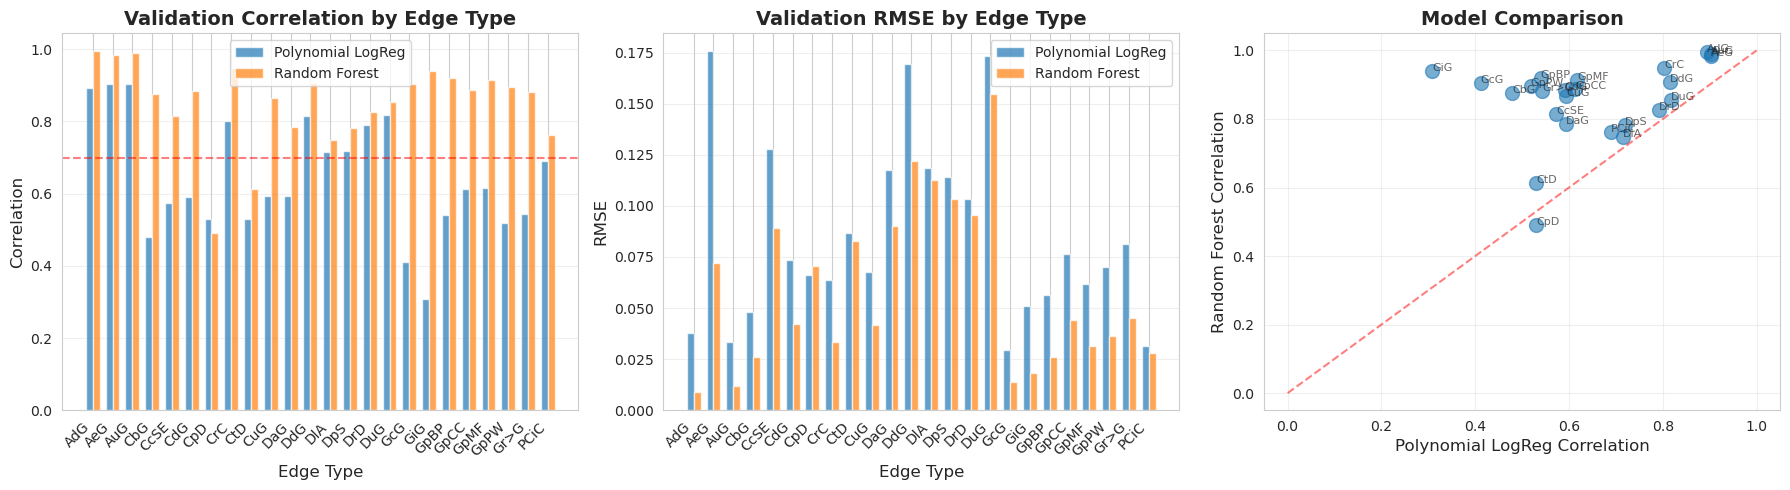

Saved validation performance plot


In [9]:
# Plot validation performance comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Correlation comparison
ax = axes[0]
x = np.arange(len(validation_df))
width = 0.35

ax.bar(x - width/2, validation_df['poly_correlation'], width, label='Polynomial LogReg', alpha=0.7)
ax.bar(x + width/2, validation_df['rf_correlation'], width, label='Random Forest', alpha=0.7)
ax.set_xlabel('Edge Type', fontsize=12)
ax.set_ylabel('Correlation', fontsize=12)
ax.set_title('Validation Correlation by Edge Type', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(validation_df['edge_type'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0.7, color='red', linestyle='--', alpha=0.5, label='Target (0.7)')

# RMSE comparison
ax = axes[1]
ax.bar(x - width/2, validation_df['poly_rmse'], width, label='Polynomial LogReg', alpha=0.7)
ax.bar(x + width/2, validation_df['rf_rmse'], width, label='Random Forest', alpha=0.7)
ax.set_xlabel('Edge Type', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Validation RMSE by Edge Type', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(validation_df['edge_type'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Scatter: Poly vs RF correlation
ax = axes[2]
ax.scatter(validation_df['poly_correlation'], validation_df['rf_correlation'], s=100, alpha=0.6)
ax.plot([0, 1], [0, 1], 'r--', alpha=0.5)
ax.set_xlabel('Polynomial LogReg Correlation', fontsize=12)
ax.set_ylabel('Random Forest Correlation', fontsize=12)
ax.set_title('Model Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

for idx, row in validation_df.iterrows():
    ax.annotate(row['edge_type'], 
               (row['poly_correlation'], row['rf_correlation']),
               fontsize=8, alpha=0.7)

plt.tight_layout()
plt.savefig(results_dir / 'validation_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved validation performance plot")

## 6. Summary Statistics

In [10]:
print("\n" + "="*70)
print("NULL MODEL TRAINING SUMMARY")
print("="*70)

print(f"\nTraining:")
print(f"  Permutations: {training_perm_range[0]}-{training_perm_range[1]-1}")
print(f"  Edge types: {len(training_df)}")
print(f"  Models created: {len(training_df) * 2} (Poly + RF)")

print(f"\nValidation:")
print(f"  Permutations: {validation_perm_range[0]}-{validation_perm_range[1]-1}")
print(f"  Edge types: {len(validation_df)}")

print(f"\nPerformance (held-out null networks):")
print(f"  Polynomial LogReg:")
print(f"    Mean correlation: {validation_df['poly_correlation'].mean():.4f} (±{validation_df['poly_correlation'].std():.4f})")
print(f"    Mean RMSE:        {validation_df['poly_rmse'].mean():.4f} (±{validation_df['poly_rmse'].std():.4f})")
print(f"  Random Forest:")
print(f"    Mean correlation: {validation_df['rf_correlation'].mean():.4f} (±{validation_df['rf_correlation'].std():.4f})")
print(f"    Mean RMSE:        {validation_df['rf_rmse'].mean():.4f} (±{validation_df['rf_rmse'].std():.4f})")

print(f"\nBest performing edge types (by RF correlation):")
top_5 = validation_df.nlargest(5, 'rf_correlation')[['edge_type', 'rf_correlation', 'rf_rmse']]
for idx, row in top_5.iterrows():
    print(f"  {row['edge_type']}: r={row['rf_correlation']:.4f}, RMSE={row['rf_rmse']:.4f}")

print(f"\nOutput files:")
print(f"  Model files: {len(list(results_dir.glob('*_null.pkl')))} + {len(list(results_dir.glob('*_features.pkl')))}")
print(f"  Validation results: {validation_file.name}")
print(f"  Training summary: {training_file.name}")
print(f"  Error analysis files: {len(list(results_dir.glob('*_error_analysis.csv')))}")

print("\n" + "="*70)
print("COMPLETE!")
print("="*70)


NULL MODEL TRAINING SUMMARY

Training:
  Permutations: 1-20
  Edge types: 24
  Models created: 48 (Poly + RF)

Validation:
  Permutations: 21-30
  Edge types: 24

Performance (held-out null networks):
  Polynomial LogReg:
    Mean correlation: 0.6455 (±0.1598)
    Mean RMSE:        0.0848 (±0.0440)
  Random Forest:
    Mean correlation: 0.8529 (±0.1164)
    Mean RMSE:        0.0583 (±0.0399)

Best performing edge types (by RF correlation):
  AdG: r=0.9945, RMSE=0.0088
  AuG: r=0.9886, RMSE=0.0117
  AeG: r=0.9840, RMSE=0.0720
  CrC: r=0.9487, RMSE=0.0334
  GiG: r=0.9405, RMSE=0.0180

Output files:
  Model files: 48 + 24
  Validation results: validation_results.csv
  Training summary: training_summary.csv
  Error analysis files: 24

COMPLETE!
